# ANALISIS EXPLORATORIO

## 1. Importación de Librerías

In [226]:
import pandas as pd 
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# from custom_utils.usedCarsImputatorVector import impute_vehicle_data_fast
warnings.filterwarnings('ignore')

In [227]:
# Crear tabla unificada con análisis de valores nulos
def analisis_valores_nulos(df):
    # Calcular estadísticas de valores nulos
    valores_nulos = df.isnull().sum()
    porcentaje_nulos = (valores_nulos / len(df)) * 100
    total_registros = len(df)
    registros_validos = total_registros - valores_nulos
    
     # Obtener tipos de datos
    tipos_datos = df.dtypes
    
    # Crear DataFrame con los resultados
    tabla_nulos = pd.DataFrame({
        'Columna': valores_nulos.index,
        'Tipo_Variable': tipos_datos.values,
        'Valores_Nulos': valores_nulos.values,
        'Registros_Validos': registros_validos.values,
        'Porcentaje_Nulos': porcentaje_nulos.values
    })
    
    # Ordenar por porcentaje de valores nulos de forma descendente
    tabla_nulos = tabla_nulos.sort_values('Porcentaje_Nulos', ascending=False)
    
    # Resetear índice
    tabla_nulos = tabla_nulos.reset_index(drop=True)
    
    return tabla_nulos

In [228]:
# Carga del dataset

parquet_url = 'https://raw.githubusercontent.com/tuliorozco/applied-statistics/3f8a3143ae31bf21bb6575e84a8d1e9d61317e82/data/vehicles.parquet'
df = pd.read_parquet(parquet_url, engine='auto')

In [229]:
# Eliminación de columnas no relevantes para el ejercicio.

df = df.drop(columns=['title_status','region','state','posting_date'], axis=1)

# Visualizacieon del encabezado del dataset
df.head()


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type
0,6000,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11900,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21000,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4900,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
df.tail()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type
426875,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,other,fwd,sedan
426876,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,other,fwd,sedan
426877,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,other,NaN,hatchback
426878,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,other,fwd,sedan
426879,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,other,rwd,coupe


De la visualización del encabezado y el final del dataframe, se evidencia que hay observaciones que cuentan únicamente con dato en la columna *price*. A continuación, se presenta un resumen del conjunto de datos. Así mismo, en las tablas se revelan otros aspectos que deben ser normalizados como son: cifras decimales en los campos *year* y *odometer* y la eliminación del texto en la característica *cylinders*, dejando únicamente el valor numérico en el atributo.

In [231]:
# Usar la función
tabla_resultados = analisis_valores_nulos(df)

# Mostrar la tabla
print("ANÁLISIS DE VALORES NULOS")
print("=" * 90)
print(tabla_resultados.to_string(index=False, float_format='%.2f'))

# Opcional: Mostrar información adicional del dataframe
print(f"\nInformación general:")
print(f"- Dimensiones del DataFrame: {df.shape}")
print(f"- Total de registros: {len(df)}")
print(f"- Total de columnas: {len(df.columns)}")
print(f"- Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

ANÁLISIS DE VALORES NULOS
     Columna Tipo_Variable  Valores_Nulos  Registros_Validos  Porcentaje_Nulos
   cylinders      category         177678             249202             41.62
   condition      category         174104             252776             40.79
       drive      category         130567             296313             30.59
        type      category          92858             334022             21.75
manufacturer      category          17646             409234              4.13
       model        object           5277             421603              1.24
    odometer       float32           4400             422480              1.03
        fuel      category           3013             423867              0.71
transmission      category           2556             424324              0.60
        year       float32           1205             425675              0.28
       price         int64              0             426880              0.00

Información general:
- Di

El anterior resumen, revela que algunos campos tienen una alta proporción de valores nulos/vacíos como es el caso de la variable *cylinders* con un 41.62% de observaciones sin información. Por lo anterior, se procede con la eliminación de todos los registros que presentan valor vacío en cualquiera de los campos.

In [232]:
# Extraer solo los números de la columna cylinders
df['cylinders'] = df['cylinders'].astype(str).str.extract('(\d+)')[0]

# Eliminar decimales (convertir a entero)
df['year'] = df['year'].fillna(0).astype(int)
df['odometer'] = df['odometer'].fillna(0).astype(int)

# Descartar marcas no asociadas a autos, SUV's 
df = df[~df['manufacturer']
        .str.lower()                # todo en minúsculas
        .str.strip()                 # quitar espacios al inicio y final
        .str.replace('-', ' ')       # guiones → espacios
        .str.replace(r'\s+', ' ', regex=True)  # colapsar espacios múltiples
        .isin(['harley davidson', 'morgan'])]

# Crear nueva columna con la edad del vehículo, millaje por año y alta demanda.
current_year = 2022  # Año actual según el contexto
df['vehicle_age'] = current_year - df['year']

df['mileage_by_year'] = np.where(
    (df['vehicle_age'] == 0) | (df['vehicle_age'] == 1),
    df['odometer'],  # Si la edad del vehículo es 0 o 1
    np.floor(df['odometer'] / df['vehicle_age'])
)

# Definición de la variable ojetivo para la clasificación.
df['high_demand'] = (df['price'] > df['price'].median()).astype(int)

# Se descartan las observaciones con valor nulo
df = df.dropna()


# se muestra el encabezado del dataframe
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,vehicle_age,mileage_by_year,high_demand
31,15000,2013,ford,f-150 xlt,excellent,6,gas,128000,automatic,rwd,truck,9,14222.0,1
32,27990,2012,gmc,sierra 2500 hd extended cab,good,8,gas,68696,other,4wd,pickup,10,6869.0,1
33,34590,2016,chevrolet,silverado 1500 double,good,6,gas,29499,other,4wd,pickup,6,4916.0,1
34,35000,2019,toyota,tacoma,excellent,6,gas,43000,automatic,4wd,truck,3,14333.0,1
35,29990,2016,chevrolet,colorado extended cab,good,6,gas,17302,other,4wd,pickup,6,2883.0,1


In [233]:
# Se evalúa el final del dataframe.
df.tail()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,vehicle_age,mileage_by_year,high_demand
426860,39990,2017,infiniti,qx80 sport utility 4d,good,8,gas,41664,automatic,4wd,other,5,8332.0,1
426866,32990,2016,infiniti,qx80 sport utility 4d,good,8,gas,55612,automatic,rwd,other,6,9268.0,1
426874,33590,2018,lexus,gs 350 sedan 4d,good,6,gas,30814,automatic,rwd,sedan,4,7703.0,1
426875,23590,2019,nissan,maxima s sedan 4d,good,6,gas,32226,other,fwd,sedan,3,10742.0,1
426878,28990,2018,lexus,es 350 sedan 4d,good,6,gas,30112,other,fwd,sedan,4,7528.0,1


In [234]:
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 68.26it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [235]:
df['year'].max()
df['price'].max()
df['vehicle_age'].max()
df['odometer'].max()

np.int64(10000000)

## 1.2. Tratamiento de Valores Atípicos

In [236]:
# Calcular el Q1 y Q3 para precio
Q1_price = df['price'].quantile(0.25)
Q3_price = df['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Definir los límites inferior y superior.
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

# Identificar los valores atípicos a partir de la columna 'price'.
outliers_price = df[(df['price'] < lower_bound_price) | (df['price'] > upper_bound_price)]
outliers_price.shape

(2347, 14)

In [237]:
# Calcular el Q1 y Q3 para precio
Q1_odometer= df['odometer'].quantile(0.25)
Q3_odometer = df['odometer'].quantile(0.75)
IQR_odometer = Q3_odometer - Q1_odometer

# Definir los límites inferior y superior.
lower_bound_odometer = Q1_odometer - 1.5 * IQR_odometer
upper_bound_odometer = Q3_odometer + 1.5 * IQR_odometer

# Identificar los valores atípicos a partir de la columna 'price'.
outliers_odometer = df[(df['odometer'] < lower_bound_odometer) | (df['odometer'] > upper_bound_odometer)]
outliers_odometer.shape

(1156, 14)

In [ ]:
outliers = pd.DataFrame()

for feat in ['price','odometer']:
    # Calcular el Q1 y Q3 para la variable.
    Q1 = df[feat].quantile(0.25)
    Q3= df[feat].quantile(0.75)
    IQR = Q3  - Q1

    # Definir los límites inferior y superior.
    lower_bound = Q1 - 1.5 * IQR
    upper_bound= Q3 + 1.5 * IQR

    # Identificar los valores atípicos a partir de la columna evaluada.
    results = df[(df[feat] < lower_bound) | (df[feat] > upper_bound)]

    # Agregar al dataframe con los valores atípicos.
    outliers = pd.concat([outliers, results], ignore_index=False)

# Eliminar las observaciones duplicadas en el dataframe outliers.
outliers = outliers.drop_duplicates()

# Mostrar las dimensiones finales del dataframe de atípicos sin valores duplicados.
outliers.shape

(2562, 14)

In [239]:
summary_stats_by_Manufacturer = df.groupby('manufacturer').agg({
    'price': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'vehicle_age': ['mean', 'median', 'std', 'min', 'max'],
    'odometer': ['mean', 'median', 'std', 'min', 'max']
}).round(0)

summary_stats_by_Year = df.groupby('year').agg({
    'price': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'vehicle_age': ['mean', 'median', 'std', 'min', 'max'],
    'odometer': ['mean', 'median', 'std', 'min', 'max']
}).round(0)

summary_stats_by_Manufacturer

price                                                     \
                     mean   median         std      min           max  count   
manufacturer                                                                   
acura             14072.0  10925.0     11386.0      0.0  8.900000e+04   1426   
alfa-romeo        18296.0  21900.0     14490.0      0.0  6.295000e+04     53   
aston-martin      51139.0  47498.0     15469.0  32900.0  6.999000e+04      6   
audi              14525.0  11985.0     12791.0      0.0  1.339950e+05   1490   
bmw               14365.0  11500.0     12096.0      0.0  1.380000e+05   3560   
buick             80968.0   8495.0   2908018.0      0.0  1.234568e+08   1802   
cadillac          15052.0  10950.0     15089.0      0.0  1.269950e+05   2069   
chevrolet         17537.0  13000.0     14832.0      0.0  1.350000e+05  19699   
chrysler           9798.0   7500.0      8088.0      0.0  8.600000e+04   2321   
datsun            12886.0  15000.0      7813.0      1.0  2.650000e+04     24   
dodge             15465.0   9995.0     21056.0      0.0  1.111111e+06   4681   
ferrari           84396.0  98900.0     48215.0      0.0  1.699990e+05     22   
fiat               8655.0   6999.0      5206.0      0.0  3.250000e+04    173   
ford              66363.0  12900.0   7388450.0      0.0  1.111111e+09  22615   
gmc               43183.0  18753.0   1650874.0      0.0  1.234568e+08   5591   
harley-davidson       NaN      NaN         NaN      NaN           NaN      0   
honda              9033.0   7200.0      6819.0      0.0  6.989100e+04   7303   
hyundai            9442.0   7995.0      6676.0      0.0  4.978800e+04   2918   
infiniti          18876.0  18999.0     11662.0      0.0  5.200000e+04   1683   
jaguar            19221.0  14900.0     18575.0      0.0  1.500000e+05    407   
jeep              18561.0  16597.0     19651.0      0.0  1.234567e+06   6902   
kia                9472.0   7999.0      7136.0      0.0  5.500000e+04   2261   
land rover        18117.0   8248.0     20784.0   3950.0  5.500000e+04      8   
lexus             18340.0  16500.0     11958.0      0.0  1.100000e+05   2765   
lincoln           17176.0  12938.0     14228.0      0.0  7.585000e+04   1330   
mazda              8518.0   6995.0      6135.0      0.0  3.699500e+04   1493   
mercedes-benz     17238.0  12900.0     15725.0      0.0  1.550000e+05   3262   
mercury            5272.0   3999.0      5135.0      0.0  6.000000e+04    561   
mini              10242.0   7995.0      7826.0      0.0  4.250000e+04    589   
mitsubishi        11890.0   7950.0     10639.0      0.0  3.990000e+04   1013   
nissan            32434.0   9199.0   1638428.0      0.0  1.350089e+08   6789   
pontiac            8348.0   5000.0      8903.0      0.0  7.400000e+04    992   
porsche           28572.0  20900.0     23740.0      0.0  1.500000e+05    400   
ram               28043.0  25888.0    240305.0      0.0  1.700000e+07   5011   
rover             23213.0  18995.0     20041.0      0.0  1.298000e+05    509   
saturn             9042.0   3995.0     95285.0      0.0  2.000000e+06    439   
subaru            10587.0   8900.0      8140.0      0.0  1.950000e+05   3063   
tesla             18544.0    946.0     30644.0      1.0  8.499900e+04     14   
toyota           339703.0   9700.0  34884850.0      0.0  3.736929e+09  11475   
volkswagen         9433.0   7995.0      6515.0      0.0  4.200000e+04   2513   
volvo              9498.0   6491.0     10338.0      0.0  1.448320e+05    883   
morgan                NaN      NaN         NaN      NaN           NaN      0   

                vehicle_age                            odometer            \
                       mean median   std   min    max      mean    median   
manufacturer                                                                
acura                  11.0   10.0   6.0   1.0  122.0  107486.0  105000.0   
alfa-romeo             17.0    5.0  16.0   2.0   48.0   45035.0   37500.0   
aston-martin           15.0   14.0

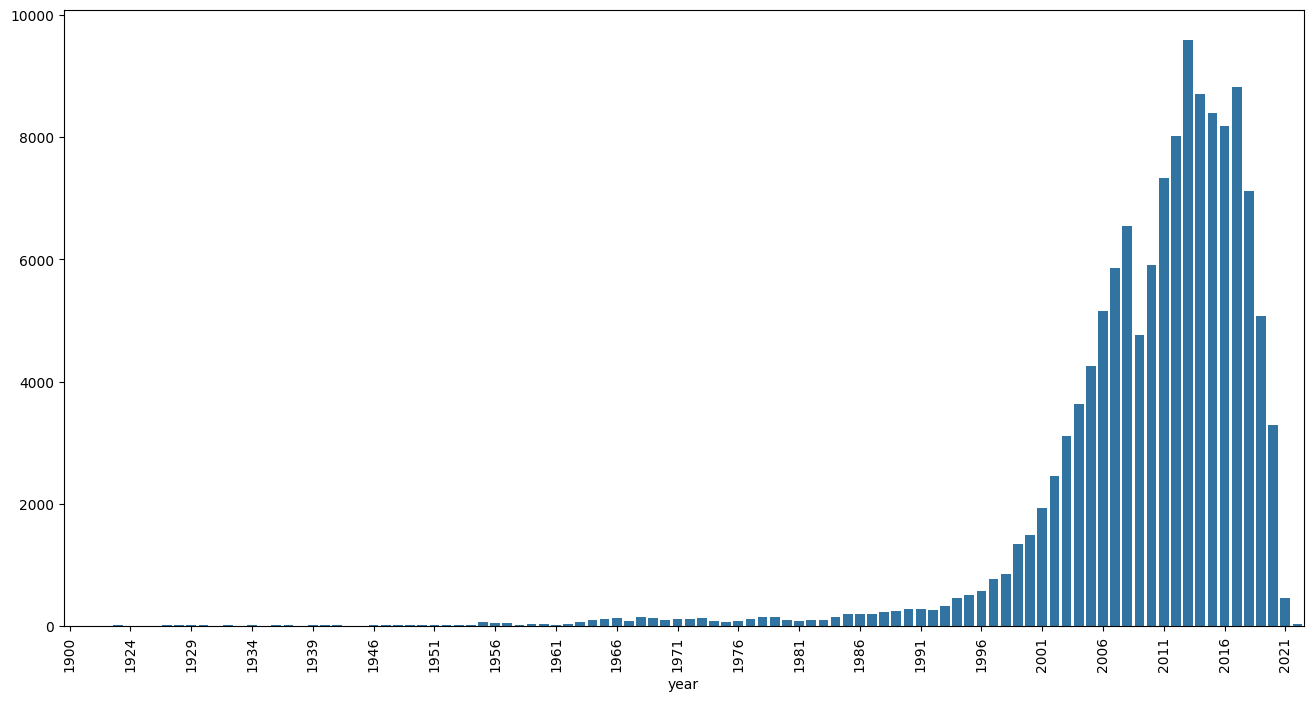

In [240]:
# ALTERNATIVA CON SEABORN (2 líneas)
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
freq_data = summary_stats_by_Year[('price', 'count')]

sns.barplot(x=freq_data.index, y=freq_data.values, ax=ax1)

# Ajustar etiquetas cada 5 años
ax1.set_xticks(range(0, len(freq_data.index), 5))
ax1.set_xticklabels(freq_data.index[::5], rotation=90)

plt.show()

La figura 1 muestra la distribución de las observaciones por el año de vehículo.

[Text(0, 0, 'acura'),
 Text(1, 0, 'alfa-romeo'),
 Text(2, 0, 'aston-martin'),
 Text(3, 0, 'audi'),
 Text(4, 0, 'bmw'),
 Text(5, 0, 'buick'),
 Text(6, 0, 'cadillac'),
 Text(7, 0, 'chevrolet'),
 Text(8, 0, 'chrysler'),
 Text(9, 0, 'datsun'),
 Text(10, 0, 'dodge'),
 Text(11, 0, 'ferrari'),
 Text(12, 0, 'fiat'),
 Text(13, 0, 'ford'),
 Text(14, 0, 'gmc'),
 Text(15, 0, 'harley-davidson'),
 Text(16, 0, 'honda'),
 Text(17, 0, 'hyundai'),
 Text(18, 0, 'infiniti'),
 Text(19, 0, 'jaguar'),
 Text(20, 0, 'jeep'),
 Text(21, 0, 'kia'),
 Text(22, 0, 'land rover'),
 Text(23, 0, 'lexus'),
 Text(24, 0, 'lincoln'),
 Text(25, 0, 'mazda'),
 Text(26, 0, 'mercedes-benz'),
 Text(27, 0, 'mercury'),
 Text(28, 0, 'mini'),
 Text(29, 0, 'mitsubishi'),
 Text(30, 0, 'nissan'),
 Text(31, 0, 'pontiac'),
 Text(32, 0, 'porsche'),
 Text(33, 0, 'ram'),
 Text(34, 0, 'rover'),
 Text(35, 0, 'saturn'),
 Text(36, 0, 'subaru'),
 Text(37, 0, 'tesla'),
 Text(38, 0, 'toyota'),
 Text(39, 0, 'volkswagen'),
 Text(40, 0, 'volvo'),
 Tex

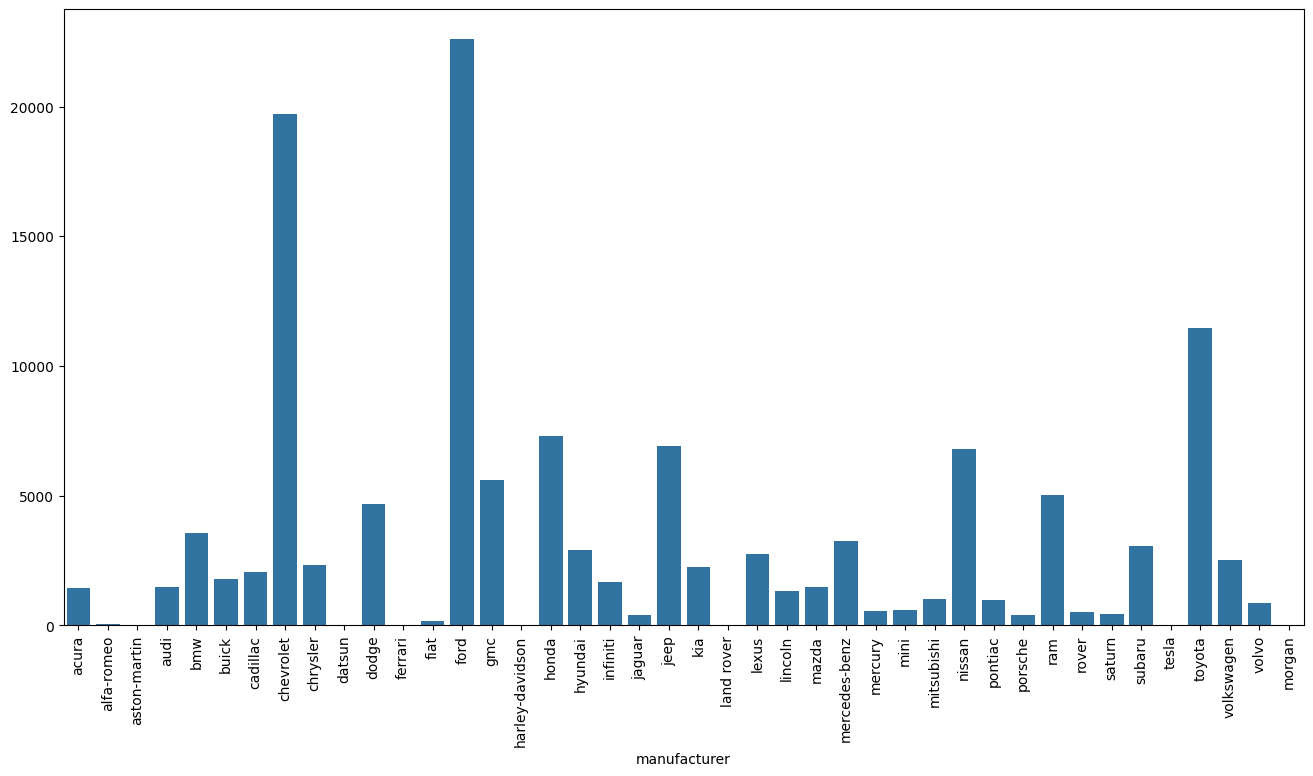

In [241]:
# ALTERNATIVA CON SEABORN (2 líneas)
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
freq_data = summary_stats_by_Manufacturer[('price', 'count')]

sns.barplot(x=freq_data.index, y=freq_data.values, ax=ax1)

# Ajustar etiquetas cada 5 años
# ax1.set_xticks(range(0, len(freq_data.index), 5))
ax1.set_xticklabels(freq_data.index, rotation=90)

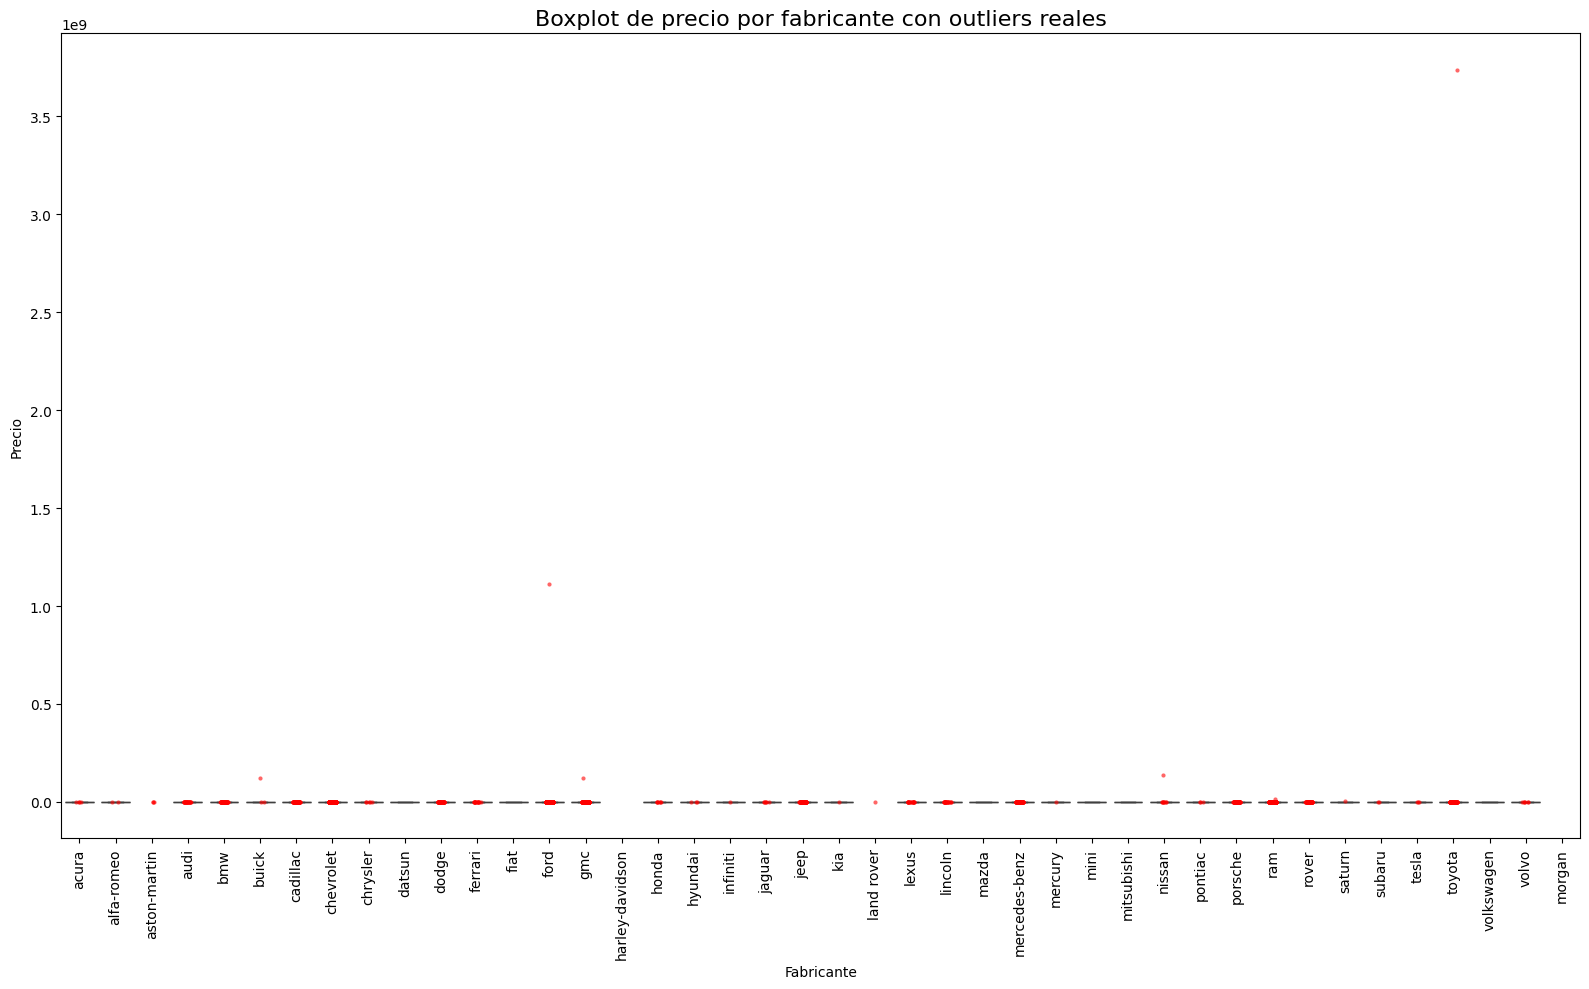

In [244]:
# --- Muestreo del 5% para que el boxplot sea rápido ---
df_sample = df.groupby('manufacturer', group_keys=False).apply(
    lambda x: x.sample(frac=0.05, random_state=42)
)

# --- Crear figura ---
plt.figure(figsize=(16, 10))

# Boxplot sin dibujar outliers automáticos
sns.boxplot(data=df_sample, x='manufacturer', y='price', showfliers=False)

# Añadir outliers reales en rojo
sns.stripplot(data=outliers_price, x='manufacturer', y='price',
              color='red', size=3, jitter=True, alpha=0.6)

# Ajustes de ejes y título
plt.xticks(rotation=90)
plt.title("Boxplot de precio por fabricante con outliers reales", fontsize=16)
plt.ylabel("Precio")
plt.xlabel("Fabricante")
plt.tight_layout()

plt.show()